In [1]:
from neuralprophet import NeuralProphet, set_log_level
import pandas as pd
import matplotlib.pyplot as plt

/Users/kirillsobolev/Documents/GitHub/ML_project/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


In [2]:
# Load all datasets, two for training and another for testing
# File adapted for starwis dataset
df1 = pd.read_csv('../ready_data/winter_2021.csv')
df2 = pd.read_csv('../ready_data/winter_2022.csv')
train_df = pd.concat([df1, df2])

test_df = pd.read_csv("../ready_data/winter_2023.csv")

# Necessary renames and other standards for prophet
train_df.rename({"ts": "ds",
           "Friction": "y"}, axis=1, inplace=True, copy=False)
# Make sure that "ds" is in pandas datetime format
train_df["ds"] = pd.to_datetime(train_df["ds"])
# Delete time zone information
train_df['ds'] = train_df['ds'].dt.tz_localize(None)
# After concatenation need to reset index, otherwise end up with duplicated indexes
train_df = train_df.reset_index(drop=True)
test_df.rename({"ts": "ds",
           "Friction": "y"}, axis=1, inplace=True, copy=False)
test_df["ds"] = pd.to_datetime(test_df["ds"])
test_df['ds'] = test_df['ds'].dt.tz_localize(None)


In [3]:
# Dict which will be used to make forecast columns
forecasts = {"airTemp": "temp_forecast",
             "humidity": "humidity_forecast",
             "dewpoint": "dewpoint_forecast",
             "precipitation": "precipitation_forecast"
             }

# Create a support columns for both datasets with forecast by shifting data to 6 points back (1 hour)
# Imitates weather forecast from the API and needed to set additional future regressors in model

for key, value in forecasts.items():
    train_df[value] = train_df[key].shift(-6)
# Since last 6 rows can't obtain any information, drop them
train_df = train_df.dropna()

for key, value in forecasts.items():
    test_df[value] = test_df[key].shift(-6)
test_df = test_df.dropna()


In [4]:
# Disable logging messages unless there is an error
set_log_level("ERROR")

WARNING - (py.warnings._showwarnmsg) - /Users/kirillsobolev/Documents/GitHub/ML_project/.venv/lib/python3.10/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /Users/kirillsobolev/Documents/GitHub/ML_project/.venv/lib/python3.10/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /Users/kirillsobolev/Documents/GitHub/ML_project/.venv/lib/python3.10/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to c

Epoch 1:   2%|▎         | 1/40 [00:00<00:00, 1724.63it/s]

WARNING - (py.warnings._showwarnmsg) - /Users/kirillsobolev/Documents/GitHub/ML_project/.venv/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 128. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.

WARNING - (py.warnings._showwarnmsg) - /Users/kirillsobolev/Documents/GitHub/ML_project/.venv/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.



Training: |          | 0/? [02:34<?, ?it/s, v_num=26, train_loss=0.0781, reg_loss=0.000, MAE=0.112, RMSE=0.142, Loss=0.0781, RegLoss=0.000]


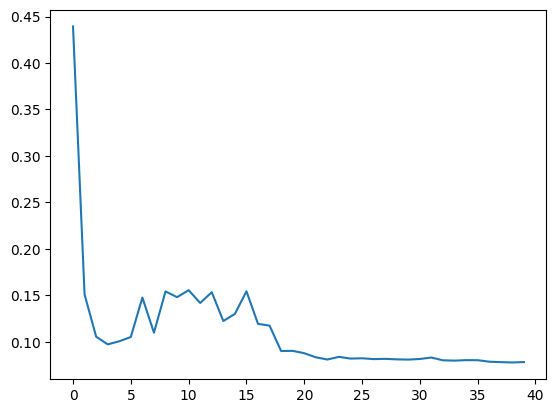

In [5]:
# Lagged regressors are the data from the past
lagged_regressors = ["airTemp", "humidity", "dewpoint",
                     "precipitation", "Water_Film_Surface_mm",
                     "Road_Surface_Temperature"]

m = NeuralProphet(n_changepoints=50,
                  yearly_seasonality=False,
                  weekly_seasonality=False,
                  daily_seasonality=True,
                  changepoints_range=1,
                  trend_reg=0.5,
                  growth="off",
                  ar_layers=[32, 16, 8, 4],
                  learning_rate=0.01,
                  quantiles=[0.2, 0.8],
                  n_forecasts=432-379
                  )
n_lags = 36

m.add_lagged_regressor(lagged_regressors, n_lags=n_lags)

# Future regressors are from future, so weather forecast for example
m.add_future_regressor("temp_forecast")
m.add_future_regressor("humidity_forecast")
m.add_future_regressor("dewpoint_forecast")
m.add_future_regressor("precipitation_forecast")

metrics = m.fit(train_df, freq="10min", progress="plot", early_stopping=True)


In [19]:

unseen_df = test_df[(test_df.ds >= "2023-11-04 00:00:00") & (test_df.ds <= "2023-11-05 00:00:00")]
original_data = unseen_df.copy(deep=True)
# Set values to NaN for rows where datetime >= 2023-11-03 15:00:00
"""test_df.loc[test_df['ds'] > pd.Timestamp("2023-11-03 15:00:00"), lagged_regressors] = None
test_df.loc[test_df['ds'] > pd.Timestamp("2023-11-03 15:00:00"), 'y'] = None"""


'test_df.loc[test_df[\'ds\'] > pd.Timestamp("2023-11-03 15:00:00"), lagged_regressors] = None\ntest_df.loc[test_df[\'ds\'] > pd.Timestamp("2023-11-03 15:00:00"), \'y\'] = None'

In [20]:
y = unseen_df[test_df.ds < "2023-11-04 16:00:00"]

WARNING - (py.warnings._showwarnmsg) - /var/folders/19/0ldx1bc54jx5tvjkrsbcv4040000gn/T/ipykernel_56513/555276178.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y = unseen_df[test_df.ds < "2023-11-04 16:00:00"]



In [32]:
future1 = m.make_future_dataframe(y, periods=1, regressors_df=test_df, n_historic_predictions=True)

WARNING - (py.warnings._showwarnmsg) - /Users/kirillsobolev/Documents/GitHub/ML_project/.venv/lib/python3.10/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /Users/kirillsobolev/Documents/GitHub/ML_project/.venv/lib/python3.10/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /Users/kirillsobolev/Documents/GitHub/ML_project/.venv/lib/python3.10/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to c

In [33]:
fcst = m.predict(future1, raw=True, decompose=False)
latest_fcst = m.get_latest_forecast(fcst, include_history_data=True)


WARNING - (py.warnings._showwarnmsg) - /Users/kirillsobolev/Documents/GitHub/ML_project/.venv/lib/python3.10/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /Users/kirillsobolev/Documents/GitHub/ML_project/.venv/lib/python3.10/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /Users/kirillsobolev/Documents/GitHub/ML_project/.venv/lib/python3.10/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to c

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.87it/s] 


KeyError: "['y'] not in index"

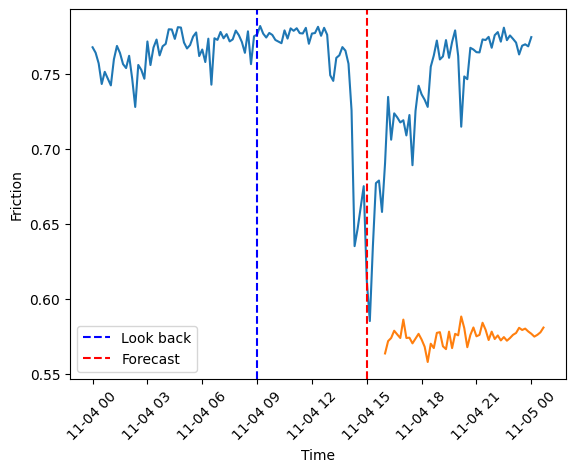

In [ ]:
# Plot the data
fig, ax = plt.subplots()
ax.plot(original_data.ds, original_data.y)
ax.plot(latest_fcst.ds, latest_fcst["origin-0"])
plt.xticks(rotation=45)
# Get the x-tick positions
xticks = ax.get_xticks()

# Add a vertical line at the 3rd x-tick

ax.axvline(x=xticks[3], color='blue', linestyle='--', label=f'Look back')
ax.axvline(x=xticks[5], color='red', linestyle='--', label=f'Forecast')
# Add labels and legend
ax.set_xlabel('Time')
ax.set_ylabel('Friction')
ax.legend()
plt.show()

In [ ]:
"""metrics.tail(1)"""

'metrics.tail(1)'